In [119]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import datetime
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sample_data
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [120]:
df = pd.read_csv('/content/inflation interest unemployment.csv')

In [121]:
df_usa = df[df['country'] == 'United States']

In [122]:
df_usa.head()

,country,year,"Inflation, consumer prices (annual %)","Inflation, GDP deflator (annual %)",Real interest rate (%),Deposit interest rate (%),Lending interest rate (%),"Unemployment, total (% of total labor force) (national estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",iso3c,iso2c,adminregion,incomeLevel
13156,United States,1970,5.838255,5.602170,2.185400,NaN,7.910000,4.9,NaN,USA,US,NaN,High income
13157,United States,1971,4.292767,5.069167,0.622605,NaN,5.723333,5.9,NaN,USA,US,NaN,High income
13158,United States,1972,3.272278,4.322751,0.887229,NaN,5.248333,5.6,NaN,USA,US,NaN,High income
13159,United States,1973,6.177760,5.479881,2.409735,NaN,8.021667,4.9,NaN,USA,US,NaN,High income
13160,United States,1974,11.054805,8.998695,1.651064,NaN,10.798333,5.6,NaN,USA,US,NaN,High income


In [123]:
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 13156 to 13207
Data columns (total 13 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   country                                                              52 non-null     object 
 1   year                                                                 52 non-null     int64  
 2   Inflation, consumer prices (annual %)                                52 non-null     float64
 3   Inflation, GDP deflator (annual %)                                   51 non-null     float64
 4   Real interest rate (%)                                               51 non-null     float64
 5   Deposit interest rate (%)                                            0 non-null      float64
 6   Lending interest rate (%)                                            52 non-null     float64
 7   Une

In [124]:
#Delete columns that are not needed
columns_to_delete = ['Deposit interest rate (%)','iso3c', 'iso2c', 'country', 'Inflation, GDP deflator (annual %)', 'adminregion', 'incomeLevel', 'Lending interest rate (%)', 'Unemployment, total (% of total labor force) (national estimate)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']
df_usa.drop(columns=columns_to_delete, inplace=True)

<ipython-input-124-2fdb815b87b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usa.drop(columns=columns_to_delete, inplace=True)


In [125]:
df_usa = df_usa.reset_index(drop = True)

In [126]:
df_usa = df_usa.drop(index = 51, axis = 0)

In [127]:
print(df_usa.columns)

Index(['year', 'Inflation, consumer prices (annual %)',
       'Real interest rate (%)'],
      dtype='object')


In [128]:
#Rename to simply Inflation
df_usa = df_usa.rename(columns={"Inflation, consumer prices (annual %)": "Inflation"})

In [129]:
for i in range(len(df_usa.columns)):
  result = adfuller(df_usa[df_usa.columns[i]])

  if result[1] > 0.05:
    print('{} - Series is not stationary'.format(df_usa.columns[i]))
  else:
    print('{} - Series is stationary'.format(df_usa.columns[i]))

year - Series is not stationary
Inflation - Series is not stationary
Real interest rate (%) - Series is not stationary


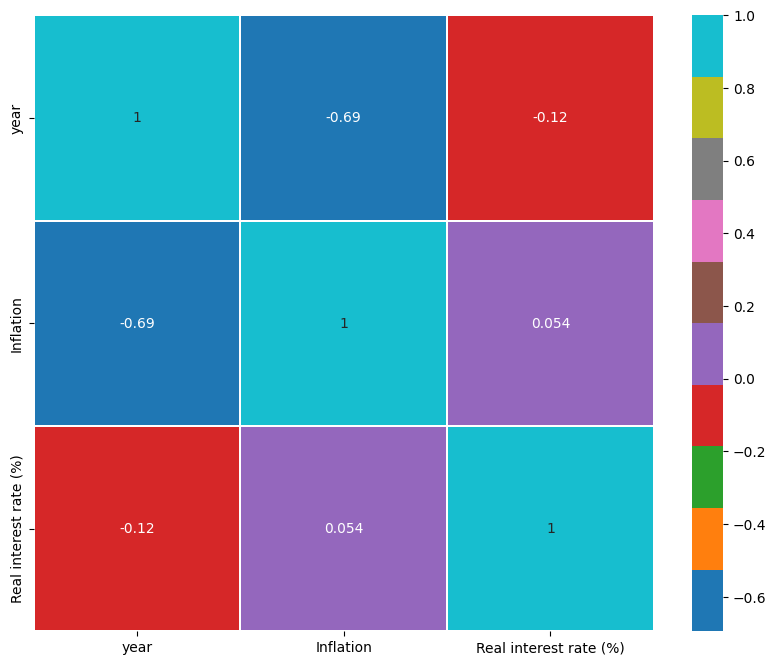

In [130]:
c=df_usa.corr()
sns.heatmap(c, cmap='tab10', linewidths='0.05', annot=True)
plt.show()

In [105]:
# Set the 'year' column as the index
df_usa.set_index('year', inplace=True)

# Differencing to make the 'Inflation' column stationary
df_usa['Inflation_diff'] = df_usa['Inflation'].diff()

# Drop missing values introduced by differencing
df_usa.dropna(inplace=True)

# Reset the index to retain 'year' as a column
df_usa.reset_index(inplace=True)

# Now, 'Inflation_diff' is the differenced (stationary) version of 'Inflation'

# Display the modified DataFrame
print("Modified DataFrame:")
print(df_usa.head())

Modified DataFrame:
   year  Inflation  Real interest rate (%)  Inflation_diff
0  1971   4.292767                0.622605       -1.545489
1  1972   3.272278                0.887229       -1.020488
2  1973   6.177760                2.409735        2.905482
3  1974  11.054805                1.651064        4.877045
4  1975   9.143147               -1.281419       -1.911658


In [106]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation'
# Assuming 'Inflation' is the column you want to predict

# Set the 'year' column as the index
df_usa.set_index('year', inplace=True)

# Specify the split point between training and testing data
split_point = int(len(df_usa) * 0.8)  # 80% for training, 20% for testing

# Split the data into training and testing sets
train_data = df_usa.iloc[:split_point]
test_data = df_usa.iloc[split_point:]

In [107]:

# Specify the lag order based on your data characteristics
lag_order = 2  # Replace with the appropriate lag order

# Fit VAR model using training data
model = VAR(train_data[['Real interest rate (%)', 'Inflation']])
results = model.fit(lag_order)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [108]:

# Forecast the next 10 steps using testing data
forecast = results.forecast(test_data[['Real interest rate (%)', 'Inflation']].values, steps=10)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, columns=['Real interest rate (%)_forecast', 'Inflation_forecast'], index=test_data.index[-10:])

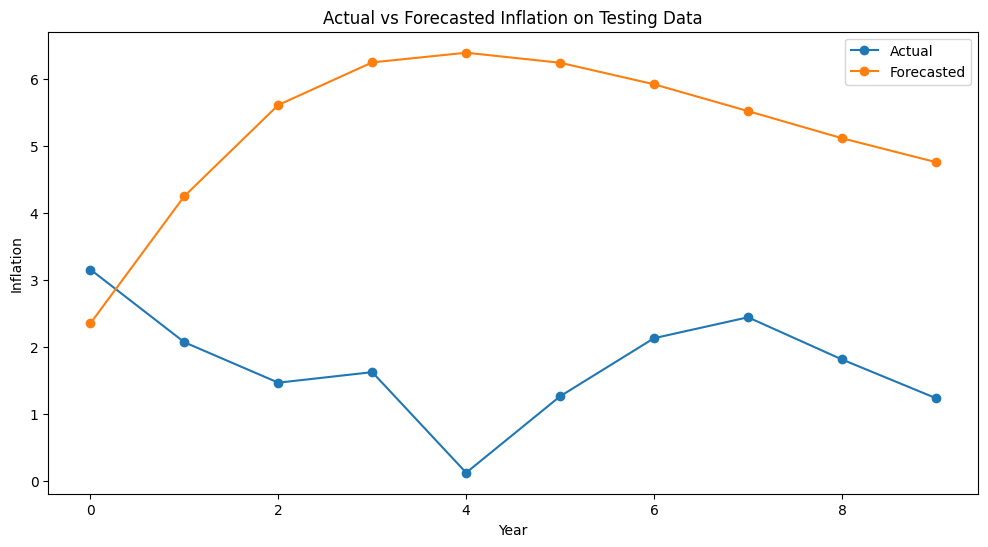

In [109]:
test_data.reset_index(inplace=True)
forecast_df.reset_index(inplace=True)
# Plot actual vs forecasted values on the testing data
plt.figure(figsize=(12, 6))
plt.plot(test_data['Inflation'], label='Actual', marker='o')
plt.plot(forecast_df['Inflation_forecast'], label='Forecasted', marker='o')
plt.title('Actual vs Forecasted Inflation on Testing Data')
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


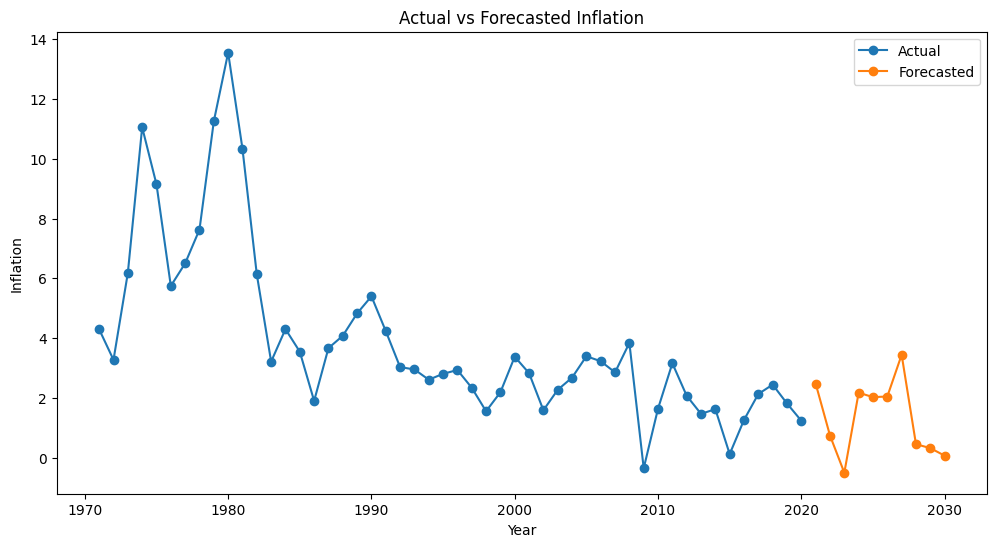

In [110]:

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation'
# Assuming you've already detrended the 'Inflation' variable if necessary



# Specify the lag order based on your data characteristics
lag_order = 14  # Replace with the appropriate lag order

# Fit VAR model
model = VAR(df_usa[['Real interest rate (%)', 'Inflation']])
results = model.fit(lag_order)

# Forecast the next 10 steps
forecast = results.forecast(df_usa[['Real interest rate (%)', 'Inflation']].values, steps=10)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, columns=['Real interest rate (%)_forecast', 'Inflation_forecast'], index=range(df_usa.index[-1] + 1, df_usa.index[-1] + 11))

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_usa['Inflation'], label='Actual', marker='o')
plt.plot(forecast_df['Inflation_forecast'], label='Forecasted', marker='o')
plt.title('Actual vs Forecasted Inflation')
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

In [111]:
print(test_data.columns)
print(forecast_df.columns)

Index(['year', 'Inflation', 'Real interest rate (%)', 'Inflation_diff'], dtype='object')
Index(['Real interest rate (%)_forecast', 'Inflation_forecast'], dtype='object')


In [112]:
test_data.reset_index(inplace=True)
forecast_df.reset_index(inplace=True)

In [113]:
print(test_data.head())
print(forecast_df.head(10))

   index  year  Inflation  Real interest rate (%)  Inflation_diff
0      0  2011   3.156842                1.137338        1.516798
1      1  2012   2.069337                1.307083       -1.087504
2      2  2013   1.464833                1.469299       -0.604505
3      3  2014   1.622223                1.374742        0.157390
4      4  2015   0.118627                2.285696       -1.503596
   index  Real interest rate (%)_forecast  Inflation_forecast
0   2021                         2.051380            2.476429
1   2022                        -1.021911            0.739856
2   2023                        -1.926554           -0.504875
3   2024                        -1.948640            2.173716
4   2025                        -1.277163            2.024661
5   2026                         1.455499            2.045284
6   2027                         1.252664            3.440848
7   2028                         0.746423            0.449560
8   2029                        -0.111451     

In [114]:
print(df_usa.columns)

Index(['Inflation', 'Real interest rate (%)', 'Inflation_diff'], dtype='object')


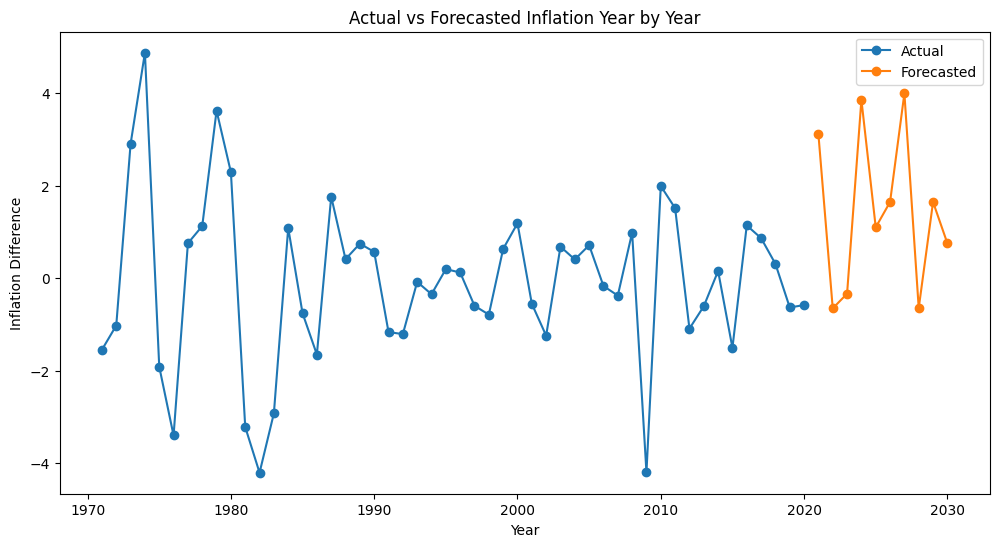

In [115]:
# Forecast the next 10 steps
forecast = results.forecast(df_usa[['Real interest rate (%)', 'Inflation_diff']].values, steps=10)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, columns=['Real interest rate (%)_forecast', 'Inflation_diff_forecast'], index=range(df_usa.index[-1] + 1, df_usa.index[-1] + 11))

# Combine the actual and forecasted values into a single DataFrame
combined_df = pd.concat([df_usa['Inflation_diff'], forecast_df['Inflation_diff_forecast']], axis=1)

# Plot actual vs forecasted values year by year
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Inflation_diff'], label='Actual', marker='o')
plt.plot(forecast_df.index, forecast_df['Inflation_diff_forecast'], label='Forecasted', marker='o')
plt.title('Actual vs Forecasted Inflation Year by Year')
plt.xlabel('Year')
plt.ylabel('Inflation Difference')
plt.legend()
plt.show()

In [118]:
# Specify the lag order based on your data characteristics
lag_order = 14  # Replace with the appropriate lag order

# Fit VAR model
model = VAR(df_usa[['Real interest rate (%)', 'Inflation']])
results = model.fit(lag_order)

# Function to predict inflation based on real interest rate input
def predict_inflation(real_interest_rate):
    input_data = pd.DataFrame({'Real interest rate (%)': [real_interest_rate]})
    forecast = results.forecast(input_data.values, steps=1)
    return forecast[0, 1]  # Extract the predicted inflation value

# Interactive user input
while True:
    try:
        real_interest_rate_input = float(input("Enter the real interest rate: "))
        predicted_inflation = predict_inflation(real_interest_rate_input)
        print(f"Predicted Inflation: {predicted_inflation:.2f}%")
    except ValueError:
        print("Invalid input. Please enter a numeric value.")
    except KeyboardInterrupt:
        print("\nExiting the program.")
        break

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Enter the real interest rate: 0.887229%
Invalid input. Please enter a numeric value.
Enter the real interest rate: 2
Invalid input. Please enter a numeric value.
Enter the real interest rate: 6.253241
Invalid input. Please enter a numeric value.
Enter the real interest rate: 2.356216%
Invalid input. Please enter a numeric value.

Exiting the program.


In [116]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation'
# Assuming you've already detrended the 'Inflation' variable if necessary

# Specify the lag order based on your data characteristics
lag_order = 14  # Replace with the appropriate lag order

# Fit VAR model
model = VAR(df_usa[['Real interest rate (%)', 'Inflation']])
results = model.fit(lag_order)

# Forecast the next 10 steps
forecast = results.forecast(df_usa[['Real interest rate (%)', 'Inflation']].values, steps=10)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, columns=['Real interest rate (%)_forecast', 'Inflation_forecast'], index=range(df_usa.index[-1] + 1, df_usa.index[-1] + 11))

# Calculate the evaluation metrics
y_true = df_usa['Inflation'].iloc[-10:]  # Actual values for the last 10 steps
y_pred = forecast_df['Inflation_forecast']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

# Print the evaluation metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 1.3186101877626912
MSE: 1.9946422345139918
RMSE: 1.4123180358948872
R-squared: -2.341149157469502


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
